## Info  
Derived from https://www.kaggle.com/dlarionov/feature-engineering-xgboost/notebook  
And later https://www.kaggle.com/felipes/feature-engineering-xgboost/edit

Use with Python 3 (eg. conda_python3)

# Build Data

In [1]:
# !pip install --upgrade numpy==1.16.1
# !pip install --upgrade --force-reinstall pandas==0.23.4
# ! conda install numba --yes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

import time
import sys
import gc
import pickle

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

## Helpers

### Visualization

In [3]:
def plotCountBy(df, by, count):
    """For each date_block_num, plot the number of 'count'
    fields for each 'by' field.

    Eg: plot how many unique items each shop sold each month."""
    
    pairs = []
    for dtb in df.date_block_num.unique():
        group = df[df.date_block_num==dtb].groupby([by])
        for nunique in group[count].count().values:
            pairs.append([dtb, nunique])
    
    x, y = zip(*pairs)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(x, y, alpha=0.2)
    ax.set_ylabel('# unique %s per %s at this date block' % (count, by), fontsize=15)
    ax.set_xlabel('Date block', fontsize=10)
    
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    
    
def plotCountRecordsBy(df, by):
    """For each "by" records that exist.

    Eg: plot how many records exist per shop_id."""
    
    pairs = []
    for value in df[by].unique():
        pairs.append([value, df[df[by] == value].shape[0]])
    
    x, y = zip(*pairs)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(x, y, color='red')
    ax.set_ylabel('# records per %s' % (by), fontsize=15)
    ax.set_xlabel('Date block', fontsize=10)
    
    ax.grid(True)
    fig.tight_layout()
    plt.show()

def plotCountUniqueBy(df, by, count):
    """For each date_block_num, plot the number of unique 'count'
    fields for each 'by' field.

    Eg: plot how many unique items each shop sold each month."""
    
    pairs = []
    for dtb in df.date_block_num.unique():
        group = df[df.date_block_num==dtb].groupby([by])
        for nunique in group[count].nunique().values:
            pairs.append([dtb, nunique])
    
    x, y = zip(*pairs)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(x, y, alpha=0.2)
    ax.set_ylabel('# unique %s per %s at this date block' % (count, by), fontsize=15)
    ax.set_xlabel('Date block', fontsize=10)
    
    ax.grid(True)
    fig.tight_layout()
    plt.show()

# Part 1: Input

In [9]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')

def sampleFromEachDateBlock(df, fraction=0.05):
#     grouped = df.groupby('shop_id', as_index=False)
    grouped = df.groupby('date_block_num', as_index=False)
    return grouped.apply(lambda x: x.sample(frac=fraction))

# _train = _train[_train.date_block_num==33]

# WARNING: There can be many unintended consequences of this. For instance,
# sampling breaks the original way of creating lagging features, because
# that supposes each entry (prod, shop) will exist for every block time,
# which won't be the case after running this.
_train = pd.read_csv('./input/sales_train.csv')
train = sampleFromEachDateBlock(_train)

# set index to ID to avoid droping it later
test = pd.read_csv('./input/test.csv').set_index('ID')

display(HTML("table <strong>train</strong>:"))
print("columns:", ",". join(train.columns.values))
print("shape:", train.shape)

columns: date,date_block_num,shop_id,item_id,item_price,item_cnt_day
shape: (146789, 6)


### Structure of train

Number of records by date_block_num is decreasing.

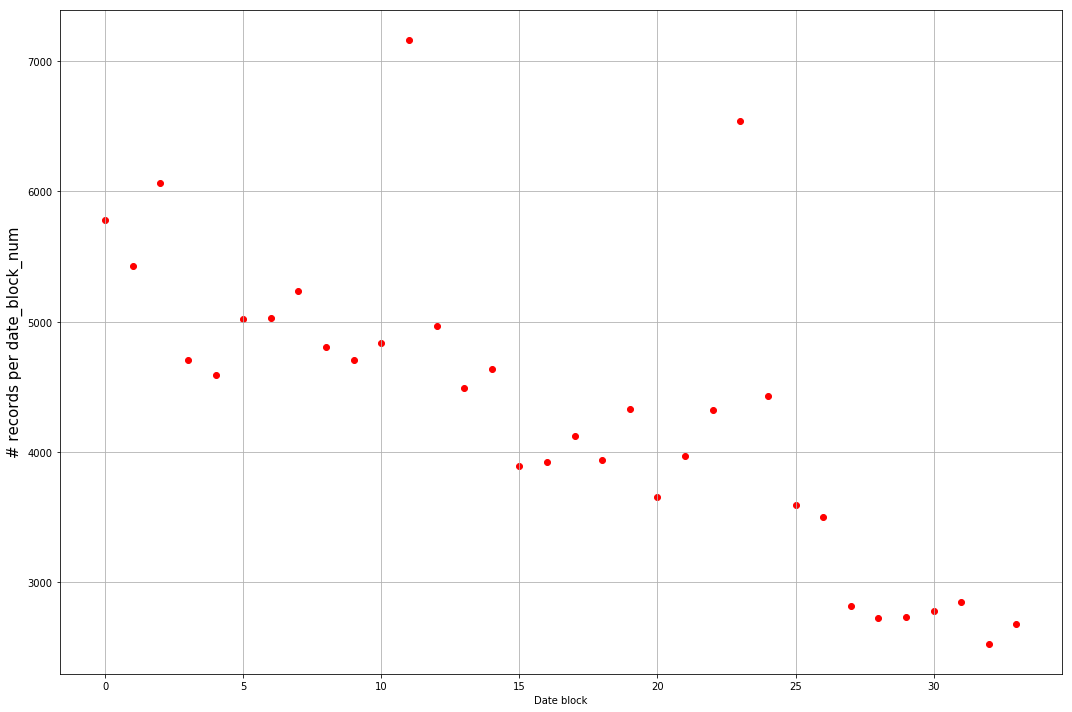

In [10]:
plotCountRecordsBy(train, 'date_block_num')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

In [11]:
# import seaborn as sns
# %matplotlib inline

# def plot_features(booster, figsize):    
#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     return plot_importance(booster=booster, ax=ax)

# plt.figure(figsize=(10,4))
# plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
# sns.boxplot(x=train.item_price)

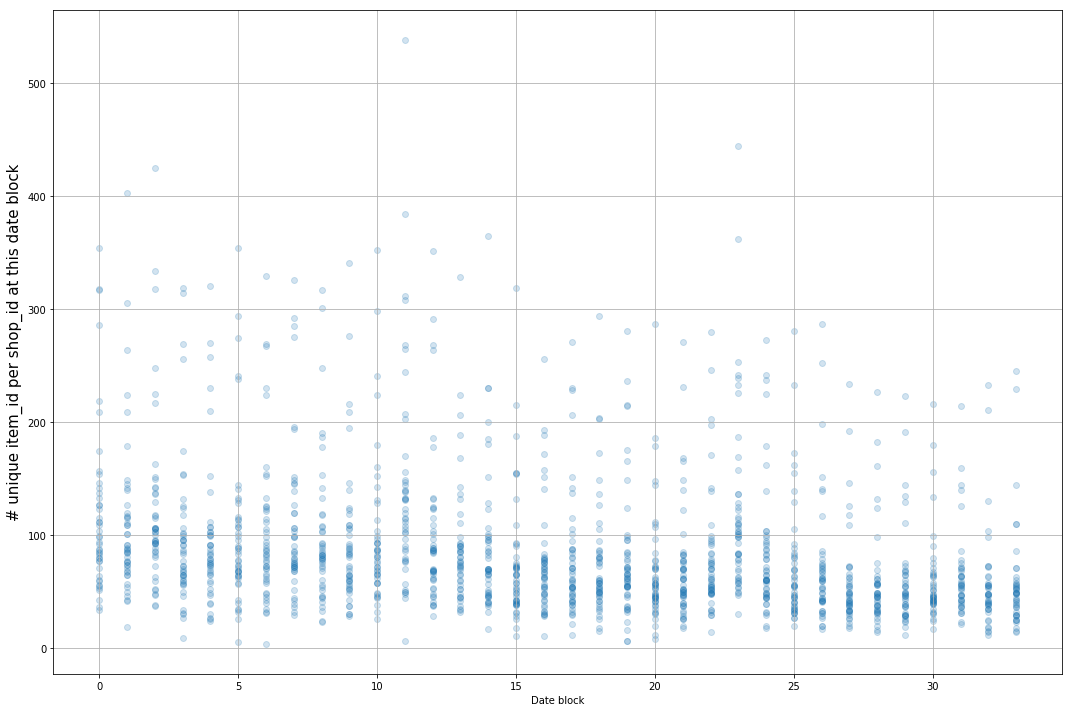

In [12]:

plotCountUniqueBy(train, 'shop_id', 'item_id')
# plotCountUniqueBy(train, 'item_id', 'shop_id')


In [13]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [14]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [15]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [16]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True) #!!!

In [17]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

train['revenue'] = (train['item_price'] *  train['item_cnt_day']).astype('int64')

pd.set_option('max_rows', 7)

## Build matrix scaffold

Basic structure of our training matrix needs to be `date_block_num x shop_id x item_id = item_ctn_month`, but train only contains such rows for which `item_ctn_month` isn't zero.

Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [18]:
%%time
#felipap: for each month, matrix contains a product of unique shop_ids x unique item_ids in it.

m2 = []
cols = ['date_block_num','shop_id','item_id']

# lesum = 0 # felipap
for i in range(34):
    sales = train[train.date_block_num==i]
    assert(len(sales))
    # lesum += len(sales.shop_id.unique()) * len(sales.item_id.unique()) # felipap
    m2.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(m2), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

CPU times: user 3.24 s, sys: 134 ms, total: 3.38 s
Wall time: 3.38 s


# `matrix` structure

We create matrix such that, for each date block, every shop has the same number of records

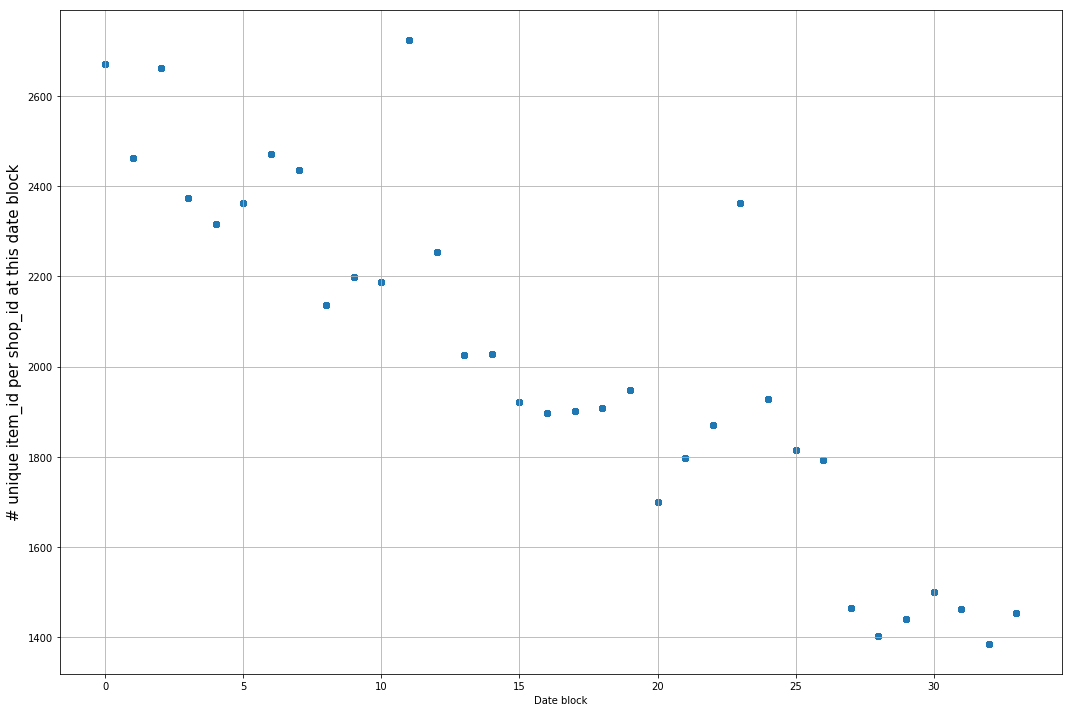

In [19]:
plotCountBy(matrix, 'shop_id', 'item_id')

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [20]:
%%time

# felipap: using 'train', which lists demand by day ('date' attr), sum up to create 'group', which lists total demand that month

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
print(group)
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

# felipap: add item_ctn_month column to 'matrix'
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

                               item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       534              1.0
                       785              1.0
                       1007             1.0
...                                     ...
33             59      19291            1.0
                       19672            1.0
                       20949            1.0

[137221 rows x 1 columns]
CPU times: user 1.06 s, sys: 104 ms, total: 1.16 s
Wall time: 1.16 s


In [21]:
%%time

# felipap: use pd.concat to add to 'matrix' the (shop_id, item_id) rows that exist in test,
# but didn't exist in train (which is where the date in 'matrix' comes from so far).
# These items (which only exist in train), whill have item_cnt_month = 'NaN', so fill them up with zeroes.

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 18.7 ms


## Shops/Items/Cats features

In [22]:
%%time

# felipap: fill in matrix the extra columns from items.csv and shops.csv

matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

matrix = matrix[matrix.date_block_num<34]

CPU times: user 1.29 s, sys: 144 ms, total: 1.43 s
Wall time: 1.43 s


## Target lags

---

# Mean encoded features

In [23]:
%%time

# TODO: rewrite variable names

def formFeat(pivot, fn, obj):
    return '%s(%s|%s)' % (fn, obj, ','.join(pivot))

def lagFeature(df, lags, lagCol, pivot):
    assert "date_block_num" in pivot
    
    wantedCols = list(set(pivot)|set([lagCol]))
    
    for i in lags:
        shifted = df[wantedCols].copy()
        # felipap: take all the rows, rename the 'item_ctn_month' to col_lag_X, and
        # merge it with the rows of i blocks in the future.
        # col_lag_X will mean: X months ago, the value was this.
        shifted.rename(columns={ lagCol: '%s_LAG_%s' % (lagCol, i)}, inplace=True)
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=list(pivot), how='left')
    return df


def createGroupBy(source, pivot, config):
    ts = time.time()
    
    
    agg = source.groupby(pivot).agg(config)
    
    # TODO: change format to eg. fn(item_ctn_month|date_block_num,type_code)
    agg.columns = [
        formFeat(pivot, col[1], col[0])
        for col in agg.columns.values
    ]
    
#     for col in agg.columns:
#         agg[col] = agg[col].astype(np.float16)
    
    agg.reset_index(inplace=True)
    return agg


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [44]:
%%time

def predictAggColumnName(aggCol, function, pivots):
    return "%s(%s|%s)" % (function, aggCol, ','.join(pivots))

def execGroupFeature(feature, source):
    pivot = feature["pivot"]
    
    newColName = predictAggColumnName(feature["aggregate"], feature["function"], pivot)
    
    aggArgs = { feature["aggregate"]: [feature["function"]] }
    grouped = createGroupBy(source, pivot, aggArgs)
    
    assert newColName in list(grouped.columns.values), \
        "newColName %s not in %s" % (newColName, grouped.columns.values)
    
    if feature.get("lags", False):
        grouped = lagFeature(grouped, feature["lags"], newColName, pivot)

    if feature.get("dropMain", False):
        assert feature.get("lags", False), "Can't dropMain unless we are lagging."
        grouped.drop(newColName, axis=1, inplace=True)
    
    return grouped

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [45]:
%%time

timeFeatures = [
    {
        "pivot": ['date_block_num'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'item_id'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1,2,3,6,12],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'shop_id'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1,2,3,6,12],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'item_category_id'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'shop_id', 'item_category_id'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'shop_id', 'type_code'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'shop_id', 'subtype_code'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'city_code'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'item_id', 'city_code'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'type_code'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
    {
        "pivot": ['date_block_num', 'subtype_code'],
        "aggregate": 'item_cnt_month',
        "function": 'mean',
        "lags": [1],
        "dropMain": True,
    },
]

matrix2 = matrix.copy()

for index, feature in enumerate(timeFeatures):
    print("\ngenerating %s/%s" % (index, len(timeFeatures)))
    grouped = execGroupFeature(feature, matrix)
    matrix2 = pd.merge(matrix2, grouped, on=feature['pivot'], how='left')

display(matrix2)


generating 0/11

generating 1/11

generating 2/11

generating 3/11

generating 4/11

generating 5/11

generating 6/11

generating 7/11

generating 8/11

generating 9/11

generating 10/11


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,mean(item_cnt_month|date_block_num)_LAG_1,"mean(item_cnt_month|date_block_num,item_id)_LAG_1","mean(item_cnt_month|date_block_num,item_id)_LAG_2","mean(item_cnt_month|date_block_num,item_id)_LAG_3","mean(item_cnt_month|date_block_num,item_id)_LAG_6","mean(item_cnt_month|date_block_num,item_id)_LAG_12","mean(item_cnt_month|date_block_num,shop_id)_LAG_1","mean(item_cnt_month|date_block_num,shop_id)_LAG_2","mean(item_cnt_month|date_block_num,shop_id)_LAG_3","mean(item_cnt_month|date_block_num,shop_id)_LAG_6","mean(item_cnt_month|date_block_num,shop_id)_LAG_12","mean(item_cnt_month|date_block_num,item_category_id)_LAG_1","mean(item_cnt_month|date_block_num,shop_id,item_category_id)_LAG_1","mean(item_cnt_month|date_block_num,shop_id,type_code)_LAG_1","mean(item_cnt_month|date_block_num,shop_id,subtype_code)_LAG_1","mean(item_cnt_month|date_block_num,city_code)_LAG_1","mean(item_cnt_month|date_block_num,item_id,city_code)_LAG_1","mean(item_cnt_month|date_block_num,type_code)_LAG_1","mean(item_cnt_month|date_block_num,subtype_code)_LAG_1"
0,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,0.0,0,37,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,35,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179444,33,59,22163,0.0,30,40,11,4,0.055573,0.023804,NaN,NaN,NaN,NaN,0.031021,0.045807,0.033997,0.035461,0.035034,0.039734,0.020096,0.018631,0.020096,0.031021,0.0,0.039551,0.039734
3179445,33,59,22164,0.0,30,37,11,1,0.055573,NaN,0.023804,0.023254,0.044434,NaN,0.031021,0.045807,0.033997,0.035461,0.035034,0.040649,0.024384,0.018631,0.017700,0.031021,NaN,0.039551,0.040466
3179446,33,59,22167,0.0,30,49,12,39,0.055573,NaN,0.071411,NaN,0.066650,0.076904,0.031021,0.045807,0.033997,0.035461,0.035034,0.040558,0.000000,0.021500,0.000000,0.031021,NaN,0.044800,0.040558


CPU times: user 9.17 s, sys: 639 ms, total: 9.81 s
Wall time: 9.8 s


---

# Trend features

Price trend for the last six months.

In [46]:
%%time

averagePrice = createGroupBy(train, ['item_id'], {'item_price': ['mean']})

averagePricePerBlock = createGroupBy(train, ['date_block_num', 'item_id'], {'item_price': ['mean']})

CPU times: user 42.9 ms, sys: 0 ns, total: 42.9 ms
Wall time: 42.1 ms


In [47]:
%%time

lags = [1,2,3,4,5,6]
grouped = lagFeature(averagePricePerBlock, lags, 'mean(item_price|date_block_num,item_id)', ['date_block_num', 'item_id'])

grouped = pd.merge(grouped, averagePrice, on=['item_id'], how='left')

for i in lags:
    grouped['delta_price_lag_%s' % i] = \
        (grouped['mean(item_price|date_block_num,item_id)_LAG_%s' % i] - grouped['mean(item_price|item_id)']) \
        / grouped['mean(item_price|item_id)']

# There must be some best practice stuff behind this that I ignore...
def selectTrend(row):
    for i in lags:
        if row['delta_price_lag_%s' % i]:
            return row['delta_price_lag_%s' % i]
    return 0

# grouped = grouped2.copy()

# Select first available trend saying if it's going up or down?
grouped['delta_price_lag'] = grouped.apply(selectTrend, axis=1)
grouped['delta_price_lag'] = grouped['delta_price_lag'].astype(np.float16)
grouped['delta_price_lag'].fillna(0, inplace=True)

grouped = grouped[['date_block_num','item_id','delta_price_lag']]

matrix3 = pd.merge(matrix2, grouped, on=['date_block_num','item_id'], how='left')


CPU times: user 2.64 s, sys: 14.8 ms, total: 2.66 s
Wall time: 2.65 s


Last month shop revenue trend

In [1]:
%%time

# TODO: document

revenueFeatures = [
    {
        "pivot": ['date_block_num','shop_id'],
        "aggregate": 'revenue',
        "function": 'sum',
    },
    {
        "pivot": ['shop_id'],
        "aggregate": 'sum(revenue|date_block_num,shop_id)',
        "function": 'mean',
    },
]

grouped0 = execGroupFeature(revenueFeatures[0], train)

grouped1 = execGroupFeature(revenueFeatures[1], grouped0)


NameError: name 'execGroupFeature' is not defined

In [134]:
%%time

# TODO: document

matrix3 = matrix2.copy()

averageRev = createGroupBy(train, ['date_block_num','shop_id'], {'revenue': ['sum']})

averageRevPerBlock = createGroupBy(averageRev, ['shop_id'], {'sum(revenue|date_block_num,shop_id)': ['mean']})

averageRev = pd.merge(averageRevPerBlock, averageRev, on=['shop_id'], how='left')

averageRev['delta_revenue'] = (averageRev['sum(revenue|date_block_num,shop_id)'] - averageRev['mean(sum(revenue|date_block_num,shop_id)|shop_id)']) / averageRev['mean(sum(revenue|date_block_num,shop_id)|shop_id)']
averageRev = averageRev[['date_block_num', 'shop_id', 'delta_revenue']]


averageRev = lagFeature(averageRev, [1], 'delta_revenue', ['date_block_num', 'shop_id'])

averageRev = averageRev[['date_block_num','shop_id','delta_revenue_LAG_1']]
# display(averageRev)

matrix3 = pd.merge(matrix3, averageRev, on=['date_block_num','shop_id'], how='left')

CPU times: user 799 ms, sys: 533 ms, total: 1.33 s
Wall time: 1.33 s


---

# Special features

In [135]:
matrix3['month'] = matrix3['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [136]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix3['days'] = matrix3['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [137]:
matrix3['item_cnt_month'] = matrix3['item_cnt_month'].astype(np.int64)

### Top-Bottom Propagation

Iterate top down propagating shit.

In [147]:
# Seems slightly faster than the iterrows method, but not worth the pain
# at the moment.

# %%time

# # https://kratzert.github.io/2017/09/21/numba-series-part-1-the-jit-decorator-and-some-more-numba-basics.html

# import numba

# matrix4 = matrix3.copy()

# @numba.jit('int64[:](int64[:],int64[:])', nopython=True)
# def propagateLastSale(date_blocks, counts):
#     lastSalesVec = np.empty(counts.shape, dtype=np.int64)
    
#     lastSale = None
#     for i in range(len(date_blocks)):
#         date_block, count = date_blocks[i], counts[i]
#         if not lastSale is None:
#             lastSalesVec[i] = date_block - lastSale
#         else:
#             lastSalesVec[i] = -1
#         if count != 0:
#             lastSale = date_block
#     return lastSalesVec

# count = 0
# def genLastSaleColumn(group):
#     global count
# #     display(group)

#     groupValues = group[['date_block_num', 'item_cnt_month']].values.T
#     a = propagateLastSale(*groupValues)
#     group['last_sales'] = a
#     count += 1
#     if count % 1000 == 0:
#         print("count %s/%s = %s" % (count, 13459, count/13459))
#     return group
    
# # matrix4 = matrix4[(matrix3.item_id>30)&(matrix3.item_id<40)]

# print(len(matrix3[matrix3.item_cnt_month != 0].groupby(['item_id', 'shop_id']).groups))
# td = matrix4[matrix4.item_cnt_month != 0].groupby(['item_id', 'shop_id']).apply(genLastSaleColumn)
# # display(td[['date_block_num', 'last_sales']].iloc[-50:])

# # sel = sel[(matrix3.item_id==22164)&(matrix3.shop_id==59)]

`len(matrix3[matrix3.item_cnt_month != 0].groupby(['item_id', 'shop_id']).groups = 13459` while without discounting the item_cnt_month, it's 288,355.

In [148]:
# Idea: this can be parallelized by partitioning matrix by different
# shop_ids

%%time
# felipap: creating totally new features
# felipap: item_shop_last_sale: months since last sale

def doit(matrix4):
    ts = time.time()
    lastSaleForItemAtShop = {}
    matrix4['item_shop_last_sale'] = -1
    count = 0
    for idx, row in matrix4.iterrows():
        if count %50000 == 0:
            print("count is", count, count/len(matrix4))
        count += 1
        key = (row.item_id, row.shop_id)
        if key not in lastSaleForItemAtShop:
            if row.item_cnt_month!=0:
                lastSaleForItemAtShop[key] = row.date_block_num
        else:
            last_date_block_num = lastSaleForItemAtShop[key]
            matrix4.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
            lastSaleForItemAtShop[key] = row.date_block_num

doit(matrix4)

matrix4['item_shop_last_sale'] = matrix4['item_shop_last_sale'].astype(np.int8)

time.time() - ts
matrix4

count is 0 0.0
count is 50000 0.015724655001069277


Exception ignored in: <function _on_type_disposal at 0x7f93369f1ae8>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numba/types/abstract.py", line 30, in _on_type_disposal
    def _on_type_disposal(wr, _pop=_typecache.pop):
KeyboardInterrupt


KeyboardInterrupt: 

In [131]:
ts = time.time()
lastSaleForItem = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

count = 0
for idx, row in matrix.iterrows():
    if count %50000 == 0:
        print("count is", count, count/len(matrix))
    count += 1
    key = row.item_id
    if key not in lastSaleForItem:
        if row.item_cnt_month!=0:
            lastSaleForItem[key] = row.date_block_num
    else:
        last_date_block_num = lastSaleForItem[key]
        # felipap: why are we checking this?
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            lastSaleForItem[key] = row.date_block_num         
time.time() - ts
matrix

count is 0 0.0
count is 50000 0.015724655001069277


KeyboardInterrupt: 

Months since the first sale for each shop/item pair and for item only.

In [ ]:
# felipap: semi-creative new features again
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

---

In [ ]:
matrix

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')

del matrix
# del cache
del lastSaleForItemAtShop, lastSaleForItem # felipap
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect()